In [448]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])

# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]



<BarContainer object of 74 artists>

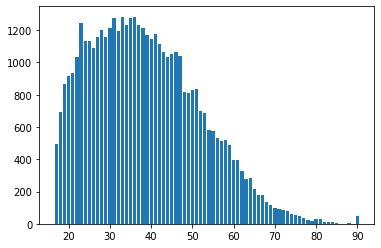

In [449]:
counts = df["Age"].value_counts()

plt.bar(counts.index, counts.values)

In [450]:
#Age is already continuous 

#Workclass needs to be converted from categorical to numerical 

workclass_mapping_dict = {
    "Private" : 0,
    "Self-emp-not-inc" : 1, 
    "Self-emp-inc" : 2, 
    "Federal-gov" : 3, 
    "Local-gov" : 4,
    "State-gov" : 5, 
    "Without-pay" : 6, 
    "Never-worked" : 7
}

df["Workclass"] = df["Workclass"].map(workclass_mapping_dict)



df

,Age,Workclass,Fnlwgt,Education,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,55,0,127677,Some-college,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States,<=50K.
1,51,4,199688,Bachelors,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
2,31,1,312055,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,70,United-States,<=50K
3,22,0,21154,HS-grad,9,Never-married,Other-service,Not-in-family,White,Female,0,1590,32,United-States,<=50K.
4,48,0,213140,Assoc-acdm,12,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,23,0,417605,5th-6th,3,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
48837,43,0,206139,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K
48839,45,0,88061,11th,7,Married-spouse-absent,Machine-op-inspct,Unmarried,Asian-Pac-Islander,Female,0,0,40,South,<=50K
48840,62,0,81534,Some-college,10,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>50K


Proportion of each category:  [73.65, 8.39, 6.86, 4.3, 3.64, 3.11, 0.05]
45222


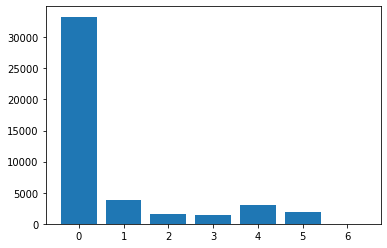

In [451]:
#Visualising Workclass data to look for imbalance
counts = df["Workclass"].value_counts()
plt.bar(counts.index, counts.values)

proportions = []
for index in counts.values:
    proportions.append(round((index/counts.values.sum() * 100),2))

#Results of this show that data is imbalanced
print("Proportion of each category: ", proportions)
print(counts.values.sum())

#Once imbalance has been rectified, need to employ one hot encoding

,Age,Workclass,Fnlwgt,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,55,0,127677,10,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,60,United-States,<=50K.
1,51,4,199688,13,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
2,31,1,312055,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,70,United-States,<=50K
3,22,0,21154,9,Never-married,Other-service,Not-in-family,White,Female,0,1590,32,United-States,<=50K.
4,48,0,213140,12,Married-civ-spouse,Sales,Husband,White,Male,0,0,60,United-States,>50K.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,23,0,417605,3,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
48837,43,0,206139,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,>50K
48839,45,0,88061,7,Married-spouse-absent,Machine-op-inspct,Unmarried,Asian-Pac-Islander,Female,0,0,40,South,<=50K
48840,62,0,81534,10,Married-civ-spouse,Sales,Husband,Asian-Pac-Islander,Male,0,0,40,United-States,>50K


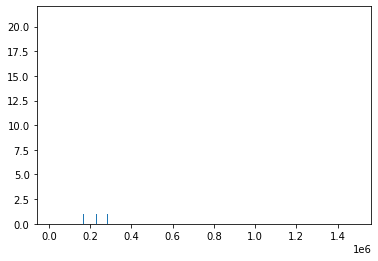

In [452]:

#Fnlwgt is already continuous
counts = df["Fnlwgt"].value_counts()
plt.bar(counts.index, counts.values)
#Education can be dropped as education-num serves the same purpose 
df.drop(columns="Education")





Proportions of each category:  [32.69, 21.89, 16.74, 5.56, 4.33, 3.58, 3.33, 2.7, 1.82, 1.74, 1.49, 1.28, 1.2, 0.99, 0.49, 0.16]


<BarContainer object of 16 artists>

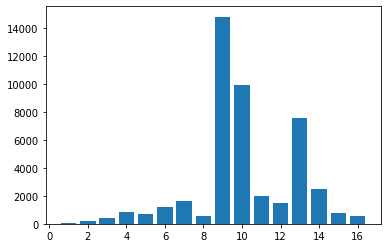

In [453]:
#Investigating distribution of Education-num 
counts = df["Education-num"].value_counts()

proportions = []
for index in counts: 
    proportions.append(round((index/counts.values.sum() * 100),2))

print("Proportions of each category: ", proportions)
plt.bar(counts.index, counts.values)

#Once imbalanced data is sorted, emply one hot encoding 

0        1
1        1
2        0
3        1
4        0
        ..
48836    1
48837    0
48839    1
48840    0
48841    0
Name: Occupation, Length: 45222, dtype: int64
Proportions of each category:  [53.87, 46.13]


<BarContainer object of 2 artists>

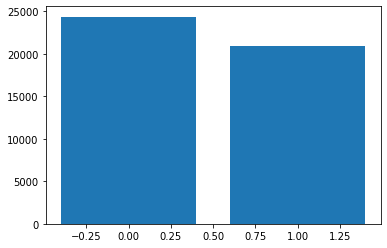

In [454]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)
print(df["Occupation"])

#Investigating distribution of Occupation
counts = df["Occupation"].value_counts()

proportions = []
for index in counts: 
    proportions.append(round((index/counts.values.sum() * 100),2))

print("Proportions of each category: ", proportions)
plt.bar(counts.index, counts.values)

#Results here show that data is not imbalanced 




Proportions of each category:  [67.5, 32.5]


<BarContainer object of 2 artists>

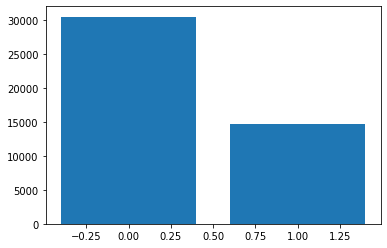

In [455]:
#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)

#Investigating distribution of Sex
counts = df["Sex"].value_counts()

proportions = []
for index in counts: 
    proportions.append(round((index/counts.values.sum() * 100),2))

print("Proportions of each category: ", proportions)
plt.bar(counts.index, counts.values)

Proportions of each category:  [46.59, 32.3, 13.93, 3.12, 2.83, 1.22]


<BarContainer object of 6 artists>

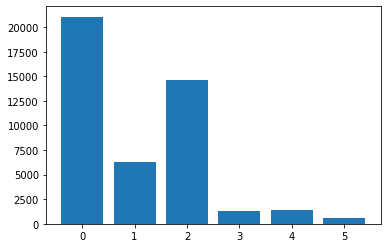

In [456]:
marital_status_mapping_dict = {
    "Married-civ-spouse" : 0, 
    "Divorced" : 1, 
    "Never-married" : 2, 
    "Widowed" : 3, 
    "Separated" :4, 
    "Married-spouse-absent" : 5, 
    "Married-AF-Spouse" : 6
}

df["Marital-status"] = df["Marital-status"].map(marital_status_mapping_dict)

counts = df["Marital-status"].value_counts()
proportions = []
for index in counts: 
    proportions.append(round((index/counts.values.sum() * 100),2))

#Print results
print("Proportions of each category: ", proportions)
plt.bar(counts.index, counts.values)

#Somewhat imbalanced data, one hot encoding should be used

[41.28, 25.88, 14.65, 10.59, 4.62, 2.98]


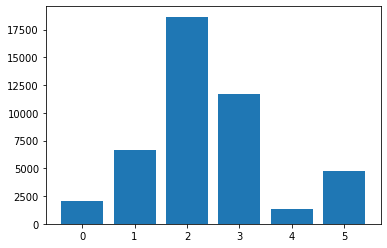

In [457]:
relationship_mapping_dict = {
    "Wife" : 0, 
    "Own-child" : 1, 
    "Husband" : 2, 
    "Not-in-family" : 3, 
    "Other-relative" : 4, 
    "Unmarried" : 5
}

df["Relationship"] = df["Relationship"].map(relationship_mapping_dict)

counts = df["Relationship"].value_counts()
proportions = []

for index in counts: 
    proportions.append(round((index/counts.sum())*100, 2))

#Printing results
print(proportions)
plt.bar(counts.index, counts.values)
df = df.dropna()




Proportions for each category:  [86.02, 9.35, 2.88, 0.96, 0.78]


/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_62366/2206818171.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Race"] = df["Race"].map(race_mapping_dict)


<BarContainer object of 5 artists>

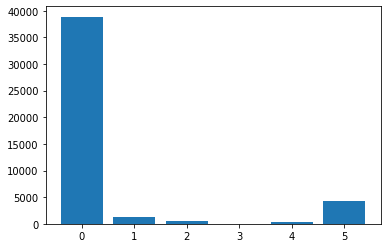

In [458]:
#Numerically encoding the race variable 

race_mapping_dict = {
    "White" : 0,
    "Asian-Pac-Islander" : 1, 
    "Amer-Indian-Eskimo" : 2, 
    "Other" : 4, 
    "Black" : 5
    }

df["Race"] = df["Race"].map(race_mapping_dict)

counts = df["Race"].value_counts()
proportions = []

for index in counts: 
    proportions.append(round((index/counts.values.sum())*100,2))

print("Proportions for each category: ", proportions)
plt.bar(counts.index, counts.values)

#Shows imbalance as well 

0        0
1        0
2        0
3        0
4        0
        ..
48836    0
48837    0
48839    0
48840    0
48841    0
Name: Capital-gain, Length: 45190, dtype: int64


<BarContainer object of 121 artists>

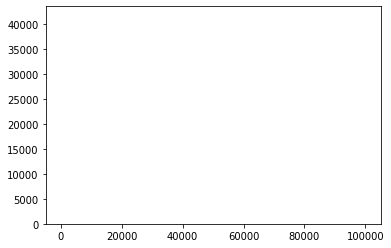

In [459]:
counts = df["Capital-gain"].value_counts()
print(df["Capital-gain"])
plt.bar(counts.index, counts.values)

<BarContainer object of 97 artists>

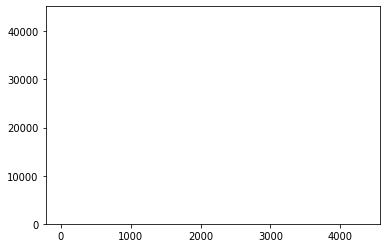

In [460]:
counts = df["Capital-loss"].value_counts()
plt.bar(counts.index, counts.values)

Proportions of each category:  [95.65, 2.28, 1.63, 0.43]


/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_62366/203155354.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Native-country"] = df["Native-country"].map(country_mapping_dict)


<BarContainer object of 4 artists>

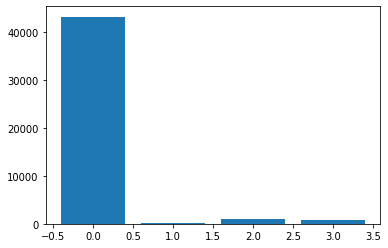

In [461]:
#Numerically encoding the native country variable 
country_mapping_dict = {
    "United-States" : 0,
    "Cambodia" :2,
    "England" : 3,
    "Puerto-Rico" : 0,
    "Canada" : 0, 
    "Germany" : 3, 
    "Outlying-US(Guam-USVI-etc)" : 0, 
    "India" : 2,
    "Japan" : 2, 
    "Greece" : 3, 
    "South" : 2, #assumes this was South Korea
    "China" : 2, 
    "Cuba" : 0, 
    "Iran" : 2,
    "Honduras" : 0,
    'Philippines' : 2, 
    'Italy' : 3,
    'Poland' : 3, 
    'Jamaica' : 0, 
    'Vietnam' : 2,
    'Mexico' : 0, 
    'Portugal' : 3, 
    'Ireland' : 3, 
    'France' : 3, 
    'Dominican-Republic' : 0, 
    'Laos' : 2, 
    'Ecuador' : 1,
    'Taiwan' : 2, 
    'Haiti' : 0,
    'Columbia' : 1, 
    'Hungary' : 3, 
    'Guatemala' : 0, 
    'Nicaragua' : 0, 
    'Scotland' : 3, 
    'Thailand' : 2, 
    'Yugoslavia' : 3, 
    'El-Salvador' : 0, 
    'Trinadad&Tobago' : 1, 
    'Peru' : 1, 
    'Hong' : 2, #This is assuming that Hong refers to Hong Kong
    'Holand-Netherlands' :3
}

df["Native-country"] = df["Native-country"].map(country_mapping_dict)

counts = df["Native-country"].value_counts()
proportions = []
for index in counts: 
    proportions.append(round(((index/counts.sum())*100),2))

print("Proportions of each category: ", proportions)
plt.bar(counts.index, counts.values)

#Shows large imbalance

<BarContainer object of 96 artists>

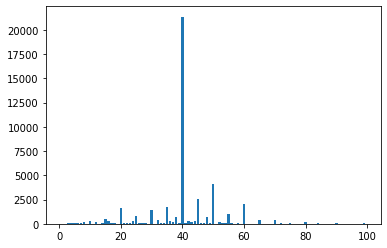

In [462]:
#Investigating the distribution of hours per week 
counts = df["Hours-per-week"].value_counts()
plt.bar(counts.index, counts.values)

#Imbalance

Proportions of each category:  [75.23, 24.77]


/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_62366/4267352864.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Income"] = df["Income"].map(income_mapping_dict)


<BarContainer object of 2 artists>

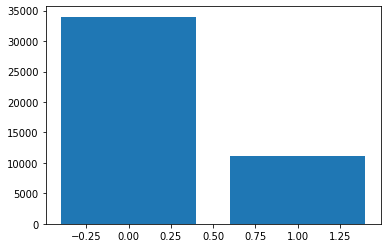

In [463]:

#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)

counts = df["Income"].value_counts()
proportions = []
for index in counts: 
    proportions.append(round(((index/counts.sum())*100),2))

print("Proportions of each category: ", proportions)
plt.bar(counts.index, counts.values)

#Can see that data is imbalanced

In [464]:



# FOR MODELS
# Group ages into discrete bins for models
bins = [10,20,30,40,50,60,70,80,90]
names = ['0', '1', '2', '3', '4', '5', '6', '7']
df['Age'] = pd.cut(df['Age'], bins, labels = names)

/var/folders/tn/fw1cv27j6bsf_4j55pn72ls80000gn/T/ipykernel_62366/980153341.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Age'] = pd.cut(df['Age'], bins, labels = names)


In [465]:
# Converting Age column data from string to numerical.
df[["Age"]] = df[["Age"]].apply(pd.to_numeric)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [466]:
#Dropping education 

df = df.drop(columns = ["Education"])
df.head()

,Age,Workclass,Fnlwgt,Education-num,Marital-status,Occupation,Relationship,Race,Sex,Capital-gain,Capital-loss,Hours-per-week,Native-country,Income
0,4,0,127677,10,0.0,1,2,0,0,0,0,60,0,0
1,4,4,199688,13,0.0,1,2,0,0,0,0,40,0,1
2,2,1,312055,9,0.0,0,2,0,0,0,0,70,0,0
3,1,0,21154,9,2.0,1,3,0,1,0,1590,32,0,0
4,3,0,213140,12,0.0,0,2,0,0,0,0,60,0,1


In [467]:
#Want to split data into X and y, then sample for training and test set usingf stratification to combat imbalances
from collections import Counter
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:, -1]


In [468]:
#Scaling all values 


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df.head()

df = scaler.fit_transform(X)

df = pd.DataFrame(X)

In [469]:
df.isna().any()

Age               False
Workclass         False
Fnlwgt            False
Education-num     False
Marital-status    False
Occupation        False
Relationship      False
Race              False
Sex               False
Capital-gain      False
Capital-loss      False
Hours-per-week    False
Native-country    False
dtype: bool

In [470]:
#Importing necessary modules
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
#Defining our model 
model = LogisticRegression(max_iter=4000)

#Using feature selection to select best attributes to be used in model training

# Create the RFE object and rank each feature
rfe = RFE(model)
rfe = rfe.fit(X, y)

# Print the features and their ranking (high = dropped early on)
print(rfe.support_)

[ True False False  True  True  True  True False  True False False False
 False]


In [471]:
#Feature selection selected columns 0, 3, 4, 5, 6, 8
#These corresponds to Age, Education-num, Marital-status, Occupation, Race
columns = ["Age", "Education-num", "Marital-status", "Relationship", "Occupation", "Race"]
X =X[columns]
X.head()

,Age,Education-num,Marital-status,Relationship,Occupation,Race
0,4,10,0.0,2,1,0
1,4,13,0.0,2,1,0
2,2,9,0.0,2,0,0
3,1,9,2.0,3,1,0
4,3,12,0.0,2,0,0


In [472]:
#From selected columns, Marital-status, relationship and Occupation need to be one hot encoded 
encoding = ["Marital-status", "Relationship", "Occupation"]

X = pd.get_dummies(X, columns = encoding)

In [473]:
#Split our dataset using stratification to combat imbalances

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)
y_train = y_train.ravel()
y_test = y_test.ravel()

In [474]:


#Define all of our hyperparameters 
solvers = ['newton-cg', 'liblinear', 'lbfgs','newton-cholesky', 'sag', 'saga']
penalty = ['l1', 'l2', 'elasticnet']
c_values = [1000, 10, 1, 0.1, 0.001, 0.001]

#Defining our search space 
space = dict(solver = solvers, penalty = penalty, C = c_values)

#Defining our cross validation
cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)

#Initialising our grid search
grid_search = GridSearchCV(estimator = model, param_grid = space, n_jobs = -1,cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Best: 0.821531 using {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'newton-cg'}
0.821443 (0.005175) with: {'C': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'newton-cholesky'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l1', 'solver': 'sag'}
0.821453 (0.005173) with: {'C': 1000, 'penalty': 'l1', 'solver': 'saga'}
0.821453 (0.005173) with: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}
0.821453 (0.005173) with: {'C': 1000, 'penalty': 'l2', 'solver': 'liblinear'}
0.821443 (0.005157) with: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
0.000000 (0.000000) with: {'C': 1000, 'penalty': 'l2', 'solver': 'newton-cholesky'}
0.821453 (0.005173) with: {'C': 1000, 'penalty': 'l2', 'solver': 'sag'}
0.821453 (0.005173) with: {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (

In [475]:
#Importing necessary libraries 
from sklearn.decomposition import PCA

#Want to use datasets of different dimensions 

model = LogisticRegression(solver = grid_result.best_params_['solver'], penalty = grid_result.best_params_['penalty'], C = grid_result.best_params_['C'])

model.fit(X_train, y_train)

original_acc = model.score(X_train, y_train)

print(X_train.shape)

#From above, we get that dimension of X_train_scaled is 36177x20

#Want to use PCA to reduce to 15, 10 and 5 and see if that has any effect 
pca = PCA(n_components=15)
X_train_15 = pca.fit_transform(X_train)
model.fit(X_train_15, y_train)
acc_15 = model.score(X_train_15, y_train)

pca = PCA(n_components=10)
X_train_10 = pca.fit_transform(X_train)
model.fit(X_train_10, y_train)
acc_10 = model.score(X_train_10, y_train)

pca = PCA(n_components=5)
X_train_5 = pca.fit_transform(X_train)
model.fit(X_train_5, y_train)
acc_5 = model.score(X_train_5, y_train)


print('Original accuracy: ', original_acc)
print('Accuracy for data reduced to 15 dimensions: ', acc_15)
print('Accuracy for data reduced to 10 dimensions: ', acc_10)
print('Accuracy for data reduced to 5 dimensions: ', acc_5)

(33892, 17)
Original accuracy:  0.821639324914434
Accuracy for data reduced to 15 dimensions:  0.8215508084503718
Accuracy for data reduced to 10 dimensions:  0.8209902041779771
Accuracy for data reduced to 5 dimensions:  0.8199870175852708


In [476]:
#From above, can see that the dimensionality reduction doesn't have much of an effect on overall accuracy
#From results above, can see that errors are generated for many of the cases. This means that for that particular 'solver', convergence isn't acheived
#Optimal set of hyperparameters is generated 

0.8214917974743302
AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

           0       0.85      0.92      0.89     25497
           1       0.69      0.52      0.59      8395

    accuracy                           0.82     33892
   macro avg       0.77      0.72      0.74     33892
weighted avg       0.81      0.82      0.81     33892



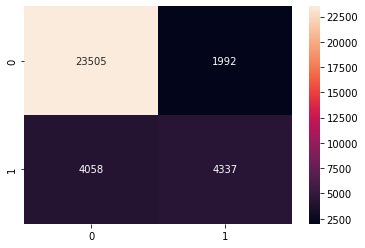

In [477]:
#Getting final evaluation metrics for Logistic Regression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

model = LogisticRegression(solver = grid_result.best_params_['solver'], penalty = grid_result.best_params_['penalty'], C = grid_result.best_params_['C'])

#Fitting the optimal version of our model
model.fit(X_train, y_train.ravel())

#Getting predictions
train_data_predictions = cross_val_predict(model, X_train, y_train.ravel(), cv=20)

print(accuracy_score(y_train, train_data_predictions))

#Getting confusion matrix 
confusion_matrix(y_train, train_data_predictions)
classes_names = ['class 1','class 2','class 3', 'class 4']
cm = pd.DataFrame(confusion_matrix(y_train, train_data_predictions))
print(sns.heatmap(cm, annot=True, fmt='d'))
print(classification_report(y_train, train_data_predictions))